In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

[LAPTOP-TL1238BG:01605] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.LAPTOP-TL1238BG.1000/jf.0/4263510016/shared_mem_cuda_pool.LAPTOP-TL1238BG could be created.
[LAPTOP-TL1238BG:01605] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


2025-06-11 18:54:25,002 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+01/s


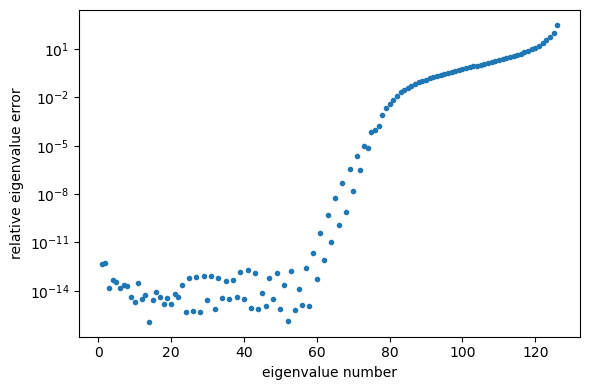

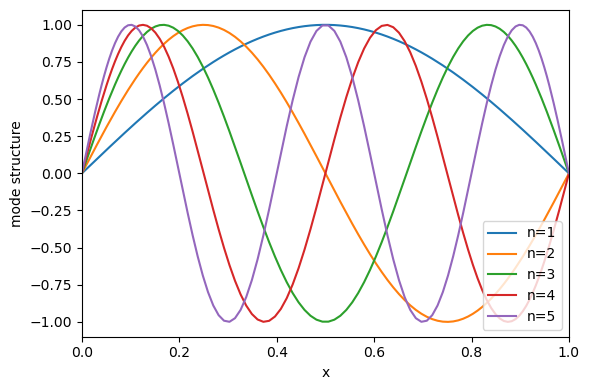

In [3]:
'''
Code solving the equation:
    -d²u/dx² = λu
To find the eigenvalue λ and then plot it against an expected equation of λ = n²π²
'''

Lx = 1

#Bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.Chebyshev(coord, 128, bounds=(0, 1), dealias=2)

#Fields
u = dist.Field(name='u', bases=basis)
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')
L = dist.Field(name='L')

#Substitutions
dx = lambda A: d3.Differentiate(A, coord)
lift_basis = basis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau1)
uxx = dx(ux) + lift(tau2)

#Problem
problem = d3.EVP([u, tau1, tau2], eigenvalue=L, namespace=locals())
problem.add_equation("- uxx - L*u = 0")
problem.add_equation("u(x=0) = 0")
problem.add_equation("u(x=1) = 0")

# Solve
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)
n = 1 + np.arange(evals.size)
true_evals = (n * np.pi)**2
relative_error = np.abs(evals - true_evals) / true_evals

# Plot
plt.figure(figsize=(6, 4))
plt.semilogy(n, relative_error, '.')
plt.xlabel("eigenvalue number")
plt.ylabel("relative eigenvalue error")
plt.tight_layout()
plt.savefig("eigenvalue_error.pdf")
plt.savefig("eigenvalue_error.png", dpi=200)

plt.figure(figsize=(6, 4))
x = dist.local_grid(basis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = (u['g'] / u['g'][1]).real
    plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}")
plt.xlim(0, 1)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.tight_layout()
plt.savefig("eigenvectors.pdf")
plt.savefig("eigenvectors.png", dpi=200)